✅ Preprocessing done in 10.13 seconds
0:	learn: 1.6225856	test: 1.6205877	best: 1.6205877 (0)	total: 252ms	remaining: 3m 52s
100:	learn: 0.5696678	test: 0.5716968	best: 0.5716968 (100)	total: 20.5s	remaining: 2m 47s
200:	learn: 0.5298475	test: 0.5314917	best: 0.5314917 (200)	total: 39.9s	remaining: 2m 23s
300:	learn: 0.5065993	test: 0.5086864	best: 0.5086864 (300)	total: 59.7s	remaining: 2m 3s
400:	learn: 0.4895526	test: 0.4915202	best: 0.4915202 (400)	total: 1m 21s	remaining: 1m 47s
500:	learn: 0.4763575	test: 0.4786266	best: 0.4786266 (500)	total: 1m 41s	remaining: 1m 25s
600:	learn: 0.4658060	test: 0.4683543	best: 0.4683543 (600)	total: 2m 2s	remaining: 1m 6s
700:	learn: 0.4567116	test: 0.4596943	best: 0.4596943 (700)	total: 2m 21s	remaining: 45.5s
800:	learn: 0.4486527	test: 0.4520265	best: 0.4520265 (800)	total: 2m 42s	remaining: 25.3s
900:	learn: 0.4415468	test: 0.4453900	best: 0.4453900 (900)	total: 3m 1s	remaining: 5.05s
925:	learn: 0.4396587	test: 0.4436297	best: 0.4436297 (92

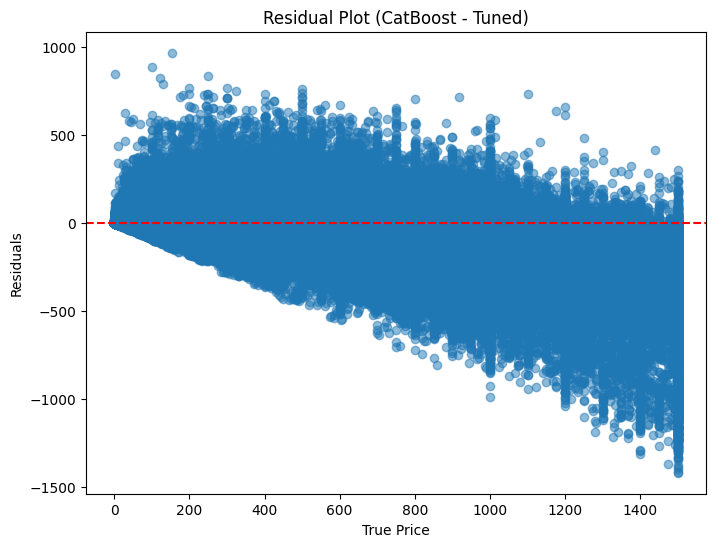

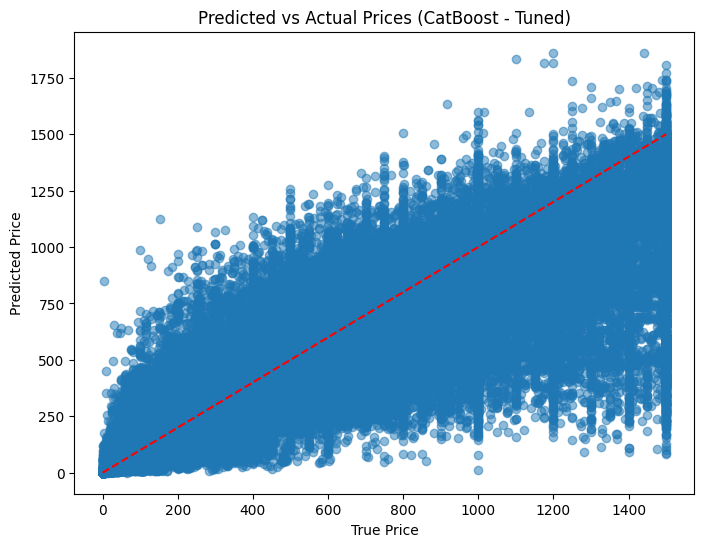

In [7]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# Configuration
n_components = 0.99
random_state = 42

def preprocess_target(y, clip_percentile=99.0):
    y_clipped = np.clip(y, 1e-6, np.percentile(y, clip_percentile))
    return np.log1p(y_clipped)

def inverse_preprocess_target(y):
    return np.expm1(y)

def cyclical_encode_month(df, col='mp_month'):
    df[f'{col}_sin'] = np.sin(2 * np.pi * (df[col] - 1) / 12)
    df[f'{col}_cos'] = np.cos(2 * np.pi * (df[col] - 1) / 12)
    return df

def remove_outliers(df, column='mp_price', iqr_multiplier=1.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - iqr_multiplier * IQR
    upper = Q3 + iqr_multiplier * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)].reset_index(drop=True)

# Load and preprocess
df = pd.read_csv("wfp_food_prices_database.csv", low_memory=False, on_bad_lines='skip')
df = df.drop(columns=["mp_commoditysource", "adm0_name", "adm1_name", "mkt_name", "cur_name", "pt_name", "um_name"], errors='ignore')
df = df[df["mp_price"] > 0].reset_index(drop=True)
df = remove_outliers(df, column='mp_price', iqr_multiplier=1.0)
df = cyclical_encode_month(df, col='mp_month')
df["adm1_mean_price"] = df.groupby("adm1_id")["mp_price"].transform("mean")

# Cast IDs to string
for col in ["adm1_id", "cm_id", "cur_id", "pt_id", "um_id"]:
    df[col] = df[col].astype(str)

# Feature selection
features = [
    "adm1_id", "cm_id", "cm_name", "cur_id", "pt_id", "um_id",
    "mp_month_sin", "mp_month_cos", "mp_year", "adm1_mean_price"
]
target = "mp_price"

X = df[features]
y = preprocess_target(df[target])

categorical = X.select_dtypes(include=["object"]).columns.tolist()
numerical = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical),
    ("cat", TargetEncoder(min_samples_leaf=5, smoothing=10.0), categorical)
])

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=n_components, random_state=random_state))
])

start_time = time.time()
X_processed = pipeline.fit_transform(X, y)
print(f"✅ Preprocessing done in {time.time() - start_time:.2f} seconds")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=random_state)

# CatBoost with best parameters
model = CatBoostRegressor(
    iterations=926,
    learning_rate=0.10611720243493492,
    depth=9,
    l2_leaf_reg=6.208342600258237,
    bagging_temperature=0.9218742350231168,
    loss_function='RMSE',
    early_stopping_rounds=50,
    random_state=random_state,
    verbose=100
)

# Train model
start_time = time.time()
model.fit(X_train, y_train, eval_set=(X_test, y_test))
print(f"✅ Training completed in {time.time() - start_time:.2f} seconds")

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_orig = inverse_preprocess_target(y_pred)
y_test_orig = inverse_preprocess_target(y_test)

mae = np.mean(np.abs(y_pred_orig - y_test_orig))
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2 = r2_score(y_test_orig, y_pred_orig)

print("\n📊 Final Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Residual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_pred_orig - y_test_orig, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True Price")
plt.ylabel("Residuals")
plt.title("Residual Plot (CatBoost - Tuned)")
plt.show()

# Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices (CatBoost - Tuned)")
plt.show()


In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.6 MB/s eta 0:00:00


In [5]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00
